# 블로그 설명

해당 자료에 대한 설명은 아래 블로그에 올려두었습니다.
- https://lsjsj92.tistory.com/606

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../data/book_kaggle/ratings.csv')
books = pd.read_csv('../data/book_kaggle/books.csv')

In [3]:
# 사용자가 어떤 book을 평가했는지에 대한 데이터
print(data.shape)
data.head()

(981756, 3)


,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [4]:
# 책에 대한 정보
print(books.shape)
books.head()

(10000, 23)


,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   book_id  981756 non-null  int64
 1   user_id  981756 non-null  int64
 2   rating   981756 non-null  int64
dtypes: int64(3)
memory usage: 22.5 MB


In [6]:
books.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   book_id                    10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

In [7]:
train, test = train_test_split(data, test_size = 0.2)
print(train.shape, test.shape)
train.head()

(785404, 3) (196352, 3)


,book_id,user_id,rating
833746,8425,41968,4
445541,4464,9820,5
64697,648,1136,2
528509,5302,30532,3
809576,8171,43077,3


In [8]:
number_of_unique_user = len(data.user_id.unique())
number_of_unique_book_id = len(data.book_id.unique())
print(number_of_unique_user, number_of_unique_book_id)

53424 10000


# 첫 번째 모델

간단한 Dot product 형태의 모델이다.   
사용자 embedding과 book embedding을 기반으로 나온 벡터 값을 Dot 연산을 통해 rating을 예측하는 방법

In [9]:
# layer 만들기
book_input = Input(shape=(1,), name='book_input_layer')
user_input = Input(shape=(1,), name='user_input_layer')

book_embedding_layer = Embedding(number_of_unique_book_id + 1, 8, name='book_embedding_layer')
user_embedding_layer = Embedding(number_of_unique_user + 1, 8, name='user_embedding_layer')

book_vector_layer = Flatten(name='book_vector_layer')
user_vector_layer = Flatten(name='user_vector_layer')

dot_result_layer = Dot(name='dot_vector_layer', axes = 1)


In [10]:
# 쌓기
book_embedding = book_embedding_layer(book_input)
user_embedding = user_embedding_layer(user_input)

book_vector = book_vector_layer(book_embedding)
user_vector = user_vector_layer(user_embedding)

dot_result = dot_result_layer([book_vector, user_vector])
model = Model(inputs=[user_input, book_input], outputs=dot_result)


In [11]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
book_input_layer (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_input_layer (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
book_embedding_layer (Embedding (None, 1, 8)         80008       book_input_layer[0][0]           
__________________________________________________________________________________________________
user_embedding_layer (Embedding (None, 1, 8)         427400      user_input_layer[0][0]           
_______________________________________________________________________________________

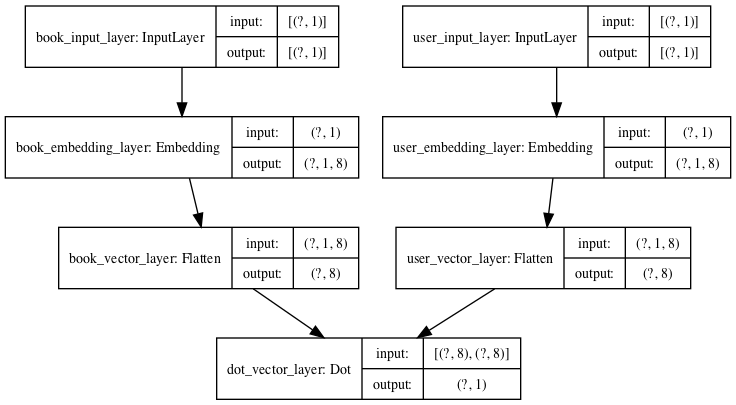

In [12]:
plot_model(model, to_file='./dot_model.png', show_shapes=True, show_layer_names=True)

In [13]:
model.compile(loss = 'mse', optimizer='adam', metrics=['mse'])

In [14]:
history = model.fit([train.user_id, train.book_id], train.rating, epochs=8, verbose=1)

Epoch 1/8
24544/24544 [==============================] - 43s 2ms/step - loss: 13.0896 - mse: 13.0896
Epoch 2/8
24544/24544 [==============================] - 43s 2ms/step - loss: 3.4429 - mse: 3.4429
Epoch 3/8
24544/24544 [==============================] - 41s 2ms/step - loss: 1.4427 - mse: 1.4427
Epoch 4/8
24544/24544 [==============================] - 42s 2ms/step - loss: 1.0189 - mse: 1.0189
Epoch 5/8
24544/24544 [==============================] - 39s 2ms/step - loss: 0.8485 - mse: 0.8485
Epoch 6/8
24544/24544 [==============================] - 38s 2ms/step - loss: 0.7596 - mse: 0.7596
Epoch 7/8
24544/24544 [==============================] - 37s 2ms/step - loss: 0.7084 - mse: 0.7084
Epoch 8/8
24544/24544 [==============================] - 36s 1ms/step - loss: 0.6741 - mse: 0.6741


Text(0, 0.5, 'training error')

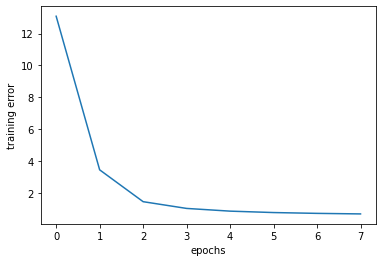

In [15]:
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('training error')

In [16]:
model.evaluate([test.user_id, test.book_id], test.rating)

6136/6136 [==============================] - 2s 303us/step - loss: 0.9524 - mse: 0.9524


[0.9524081945419312, 0.9524081945419312]

In [17]:
predictions = model.predict([test.user_id.head(10), test.book_id.head(10)])

for p, t in zip(predictions, test.rating.values[:10]):
    print(p, t)

[3.0390196] 4
[3.4663684] 5
[4.4353533] 4
[5.022065] 5
[1.3333156] 2
[3.702732] 4
[3.8910027] 5
[4.9327035] 4
[4.0983667] 4
[3.0378323] 3


# 2. Dense layer (Neural Network로 만들기)

위에서는 단순하게 Dot을 이용해서 rating을 예측하는 형태로 만들었다.   
이번에는 Dense layer를 이용해서 layer를 쌓고 rating을 예측하는 방법을 적용해본다.

In [19]:
# layer 쌓기

book_input = Input(shape=(1, ), name='book_input_layer')
user_input = Input(shape=(1, ), name='user_input_layer')

book_embedding_layer = Embedding(number_of_unique_book_id + 1, 8, name='book_embedding_layer')
user_embedding_layer = Embedding(number_of_unique_user + 1, 8, name='user_embedding_layer')

book_vector_layer = Flatten(name='book_vector_layer')
user_vector_layer = Flatten(name='user_vector_layer')

concate_layer = Concatenate()

dense_layer1 = Dense(128, activation='relu')
dense_layer2 = Dense(32, activation='relu')

result_layer = Dense(1)

In [20]:
# 쌓기
book_embedding = book_embedding_layer(book_input)
user_embedding = user_embedding_layer(user_input)

book_vector = book_vector_layer(book_embedding)
user_vector = user_vector_layer(user_embedding)

concat = concate_layer([book_vector, user_vector])
dense1 = dense_layer1(concat)
dense2 = dense_layer2(dense1)

result = result_layer(dense2)

model = Model(inputs=[user_input, book_input], outputs=result)

In [21]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
book_input_layer (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_input_layer (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
book_embedding_layer (Embedding (None, 1, 8)         80008       book_input_layer[0][0]           
__________________________________________________________________________________________________
user_embedding_layer (Embedding (None, 1, 8)         427400      user_input_layer[0][0]           
_______________________________________________________________________________________

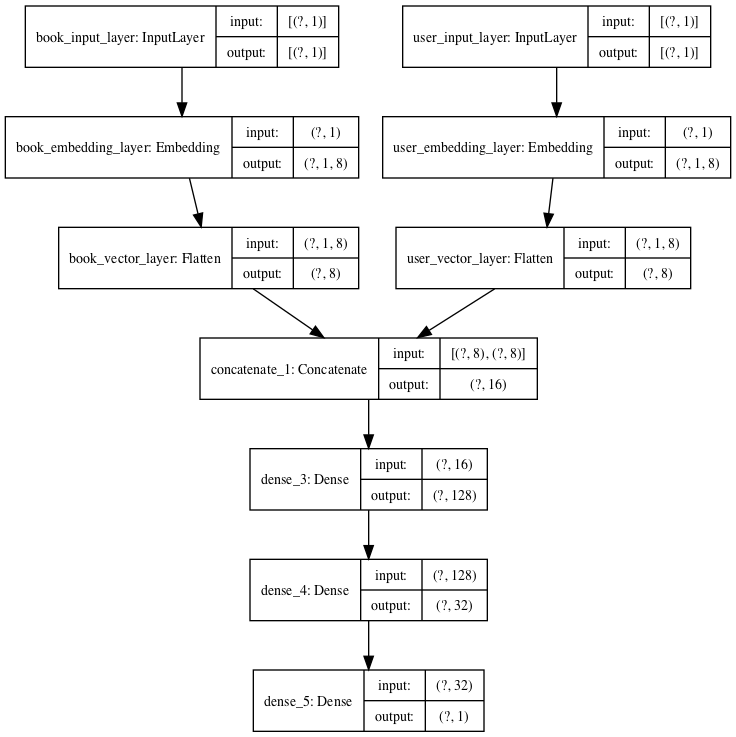

In [22]:
plot_model(model, to_file='./dense_predict_model.png', show_shapes=True, show_layer_names=True)

In [23]:
model.compile(loss = 'mse', optimizer='adam', metrics=['mse'])

In [24]:
history = model.fit([train.user_id, train.book_id], train.rating, epochs=8, verbose=1)

Epoch 1/8
24544/24544 [==============================] - 43s 2ms/step - loss: 0.7982 - mse: 0.7982
Epoch 2/8
24544/24544 [==============================] - 37s 2ms/step - loss: 0.6871 - mse: 0.6871
Epoch 3/8
24544/24544 [==============================] - 37s 2ms/step - loss: 0.6526 - mse: 0.6526
Epoch 4/8
24544/24544 [==============================] - 38s 2ms/step - loss: 0.6243 - mse: 0.6243
Epoch 5/8
24544/24544 [==============================] - 38s 2ms/step - loss: 0.5966 - mse: 0.5966
Epoch 6/8
24544/24544 [==============================] - 44s 2ms/step - loss: 0.5686 - mse: 0.5686
Epoch 7/8
24544/24544 [==============================] - 40s 2ms/step - loss: 0.5433 - mse: 0.5433
Epoch 8/8
24544/24544 [==============================] - 42s 2ms/step - loss: 0.5200 - mse: 0.5200


Text(0, 0.5, 'training error')

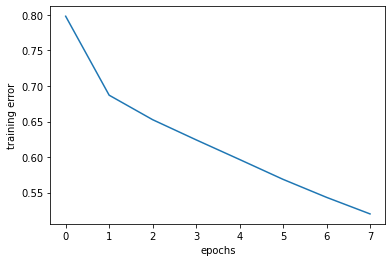

In [25]:
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('training error')

In [26]:
model.evaluate([test.user_id, test.book_id], test.rating)

6136/6136 [==============================] - 2s 349us/step - loss: 0.7414 - mse: 0.7414


[0.7414111495018005, 0.7414111495018005]

In [27]:
predictions = model.predict([test.user_id.head(10), test.book_id.head(10)])

for p, t in zip(predictions, test.rating.values[:10]):
    print(p, t)

[2.7931433] 4
[4.2889414] 5
[4.764618] 4
[4.2071877] 5
[3.5028908] 2
[3.7568953] 4
[4.081534] 5
[4.465719] 4
[3.6455593] 4
[3.799435] 3


In [28]:
tmp_book_data = np.array(list(set(data.book_id)))[:1000]
tmp_user = np.array([1 for i in range(1000)])


In [31]:
print(tmp_book_data[:10])
print(tmp_user[:10])

[ 1  2  3  4  5  6  7  8  9 10]
[1 1 1 1 1 1 1 1 1 1]


In [30]:
predictions = model.predict([tmp_user, tmp_book_data])
predictions = np.array([p[0] for p in predictions])
print(predictions[:5])

[4.232527  4.4912014 2.74577   4.705388  3.6804   ]


In [42]:
# id는 1부터 시작인데 argsort를 하면 0부터 되므로 1을 더한다.
recommended_book_ids = (-predictions).argsort()[:5] + 1
print(recommended_book_ids)

[862 610 780 950   4]


In [43]:
books[books['id'].isin(recommended_book_ids)]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
609,610,16158542,16158542,21998925,33,067002581X,9.780670e+12,Daniel James Brown,2013.0,The Boys in the Boat: Nine Americans and Their...,...,113565,139128,16287,2292,3772,15002,43457,74605,https://images.gr-assets.com/books/1354683116m...,https://images.gr-assets.com/books/1354683116s...
779,780,77727,77727,2110010,24,836220889,9.780836e+12,"Bill Watterson, G.B. Trudeau",1987.0,Calvin and Hobbes,...,117788,118294,684,980,1435,7684,22365,85830,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
861,862,17332218,17332218,16482835,34,765326361,9.780765e+12,Brandon Sanderson,2014.0,Words of Radiance,...,73572,108176,7261,154,404,2653,18272,86693,https://images.gr-assets.com/books/1391535251m...,https://images.gr-assets.com/books/1391535251s...
949,950,20820994,20820994,11409817,71,803734964,9.780804e+12,Jandy Nelson,2014.0,I'll Give You the Sun,...,140937,153584,16701,7025,7517,20793,40241,78008,https://images.gr-assets.com/books/1496659336m...,https://images.gr-assets.com/books/1496659336s...
